# Descriptive statistics of the extracted data

We provide visualizations of the distribution of the data availability over time and space.

In [91]:
import bluesquare_data_pipelines.access as blsq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [92]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [94]:
#hivdr = blsq.dhis_instance("dhis2_cd_hivdr_prod")

In [95]:
#report = hivdr.get_reported_de()

In [96]:
full_data.head()

,monthly,quarterly,dataelementname,catcomboname,population,action,sub_population,province,fosa,value
0,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
1,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
2,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
3,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
4,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"5 et 9 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0


In [97]:
def impute_zero_dataelementname(df):

    """ This function is used to populate a pandas dfs with rows for each data element and zero imputed value
    where at least one value for fosa x period x data element exists in the data.

    :param df: This is a pandas df that has rows only for manually inputed data element.

    :return: out: This function returns a pandas df augmented with extra rows for every existing data element.
    """

    import pandas as pd

    out = []

    list_fosa = df.fosa.unique()

    for fosa in list_fosa:
        sub_df = df[df.fosa == fosa]
        # first, drop duplicates in month x data element, then create a contigency table month x dataelement
        sub_df_piv = sub_df.drop_duplicates(subset=["monthly","dataelementname"], keep='last').pivot(index="monthly", columns="dataelementname", values=["value"])
        # second, stacked the values to go back to a df format with one row per month and data element
        # we replace NAs by 0, as we think that if a report was filled out, the missing values are really zeros
        sub_df_piv_stacked = sub_df_piv.fillna(0).stack()
        sub_df_piv_stacked = pd.DataFrame(sub_df_piv_stacked)
        sub_df_piv_stacked = sub_df_piv_stacked.reset_index()
        # finally, we merged it back with the original data frame
        #sub_df_col = sub_df[["province","fosa","monthly","quarterly"]]
        new_df = sub_df.merge(sub_df_piv_stacked, how = 'outer')

        out.append(new_df)
    # return the transformed data frame
    df_augmented = pd.concat(out)
    return(df_augmented)

In [98]:
full_data_imp = impute_zero_dataelementname(full_data)

In [170]:
#len(full_data)

In [171]:
#len(full_data_imp)

In [172]:
#full_data_imp.head()

In [173]:
#len(full_data_imp.monthly.unique().tolist())

In [174]:
#len(full_data_imp.province.unique().tolist())

In [175]:
#len(full_data_imp.fosa.unique().tolist())

In [176]:
#full_data_imp.groupby(['monthly']).describe()

In [177]:
count_fosa = full_data_imp.groupby(['fosa']).count().unstack()
#count_fosa.head(n=20)

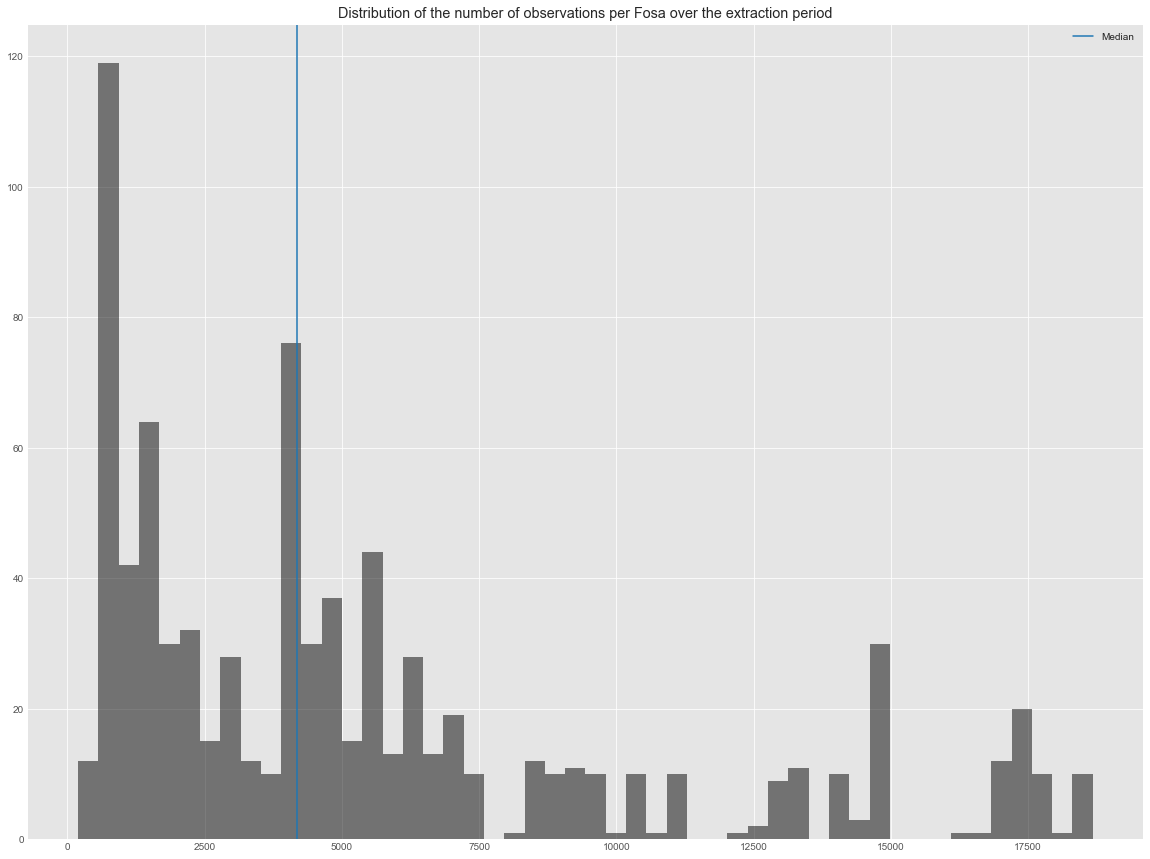

In [178]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(1,1,1)
    ax1.hist(count_fosa,bins=50,color='k',alpha=0.5)
    ax1.axvline(x=count_fosa.median(),label='Median')
    ax1.legend(loc='best')
    
    plt.title("Distribution of the number of observations per Fosa over the extraction period")

In [158]:
sub_data = full_data_imp['province']
count_province = pd.Series.value_counts(sub_data)
#count_province = sub_data.groupby(['province']).count().unstack()
#count_province.head(n=50)
count_province = pd.Series.to_frame(count_province, name = 'Count')
count_province['province']=count_province.index

In [159]:
count_province['adminid'] = count_province['province'].str.lower().astype(str).str[-4:]

In [160]:
import geopandas as gpd
shapefile = gpd.read_file("../data/ZAI.shp")
shapefile['adminid'] = shapefile.loc[:,'ADM1'].str.lower().astype(str).str[-4:]
shapefile = shapefile.reset_index()
shape_data = shapefile.merge(count_province, on = 'adminid', how = "outer")

### Data availability spatial pattern
We look at the spatial distribution of data availability; the darker the more information we have at disposal in the data.

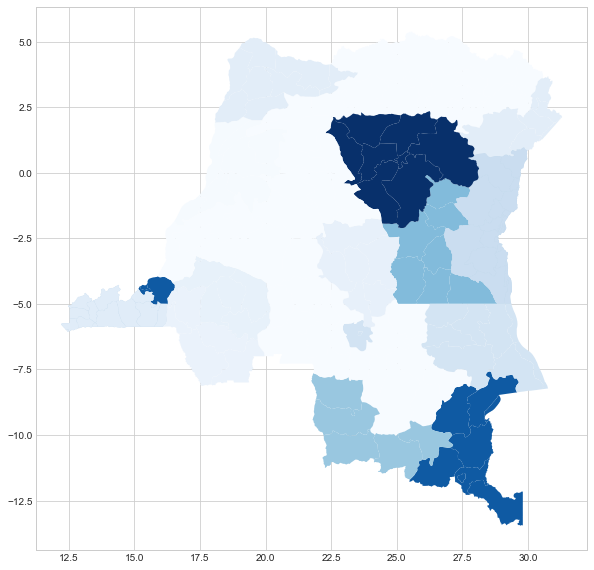

In [162]:
import descartes
shape_data.plot(figsize=(10,10), column = 'Count', cmap = 'Blues')

In [167]:
full_data_imp['year'] = full_data_imp["monthly"].astype(str).str[:4]#.unique().tolist()
full_data_imp['date'] = pd.to_datetime(full_data_imp["monthly"], format='%Y%m', errors='ignore')

In [168]:
count_fosa_year = full_data_imp.groupby(['fosa','year']).count().unstack()
count_fosa_year = count_fosa_year.dropna(axis=0, how='all')
#count_fosa_year.head(n=20)

### Variations over time

Another question of interest is the variability in the information available in each *fosa* from one year to another.

Text(0.5, 1.0, 'Scatterplot of the number of observations per Fosa in 2017 and 2018')

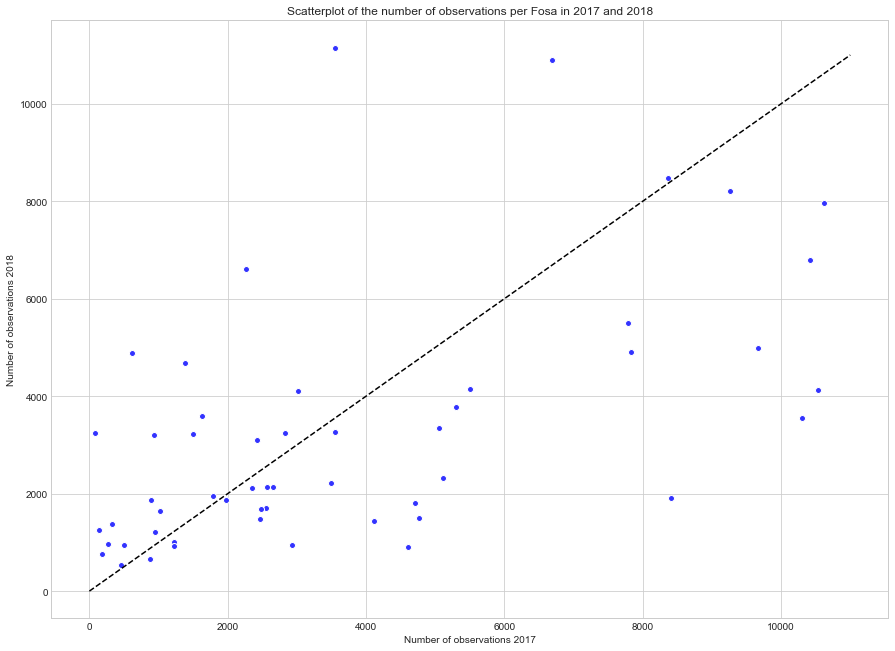

In [87]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(1,1,1)
ax.scatter(count_fosa_year['value']['2017'],count_fosa_year['value']['2018'], color="#3333FF", edgecolors='#FFFFFF')
plt.plot([0, 11000], [0, 11000], 'k-',linestyle='dashed')
plt.xlabel('Number of observations 2017')
plt.ylabel('Number of observations 2018')

plt.title("Scatterplot of the number of observations per Fosa in 2017 and 2018")

In [169]:
count_month = full_data_imp.groupby(['date']).count()
#count_month.head()

### Overall number of data element over time (month)

Text(0.5, 1.0, 'Distribution of the number of observations per month over time')

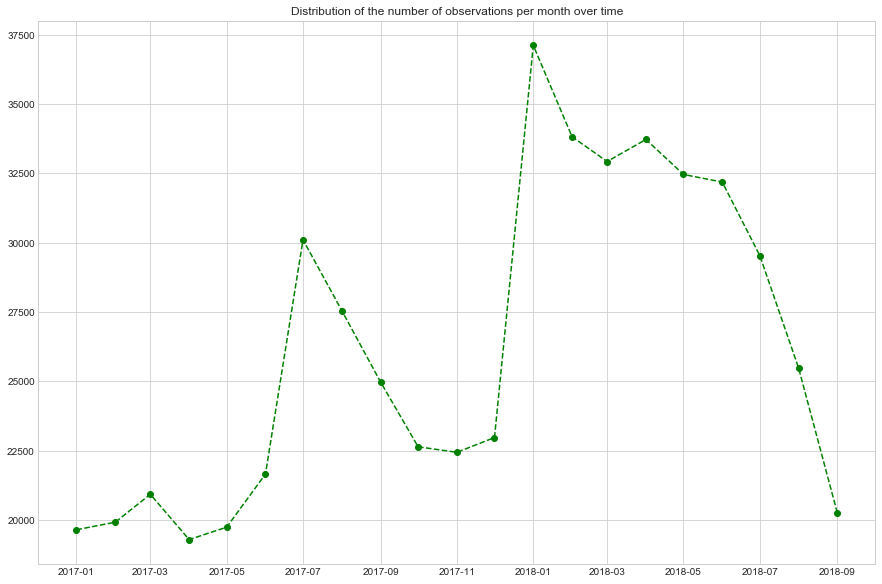

In [81]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.plot(count_month.value,color='g',marker='o',linestyle='dashed')
plt.title("Distribution of the number of observations per month over time")

In [163]:
#with sns.axes_style("ticks"):
#    fig = plt.figure(figsize=(15,8))
#    ax1 = fig.add_subplot(1,1,1)
#    plt.plot(count_month.value)
#    plt.title("Distribution of the number of observations per month over time")

In [164]:
#with plt.style.context('ggplot'):
#    fig = plt.figure(figsize=(20,15))
#    ax1 = fig.add_subplot(1,1,1)
#    ax1.hist(count_month,bins=50,color='k',alpha=0.5)
#    ax1.axvline(x=count_month.median(),label='Median')
#    ax1.legend(loc='best')
    
#    plt.title("Distribution of the number of observations per month over the extraction period")